In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pickle
import xgboost as xgb

In [3]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
# adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(' ', '_')
label = adata.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [4]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4 T,CD4_TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [5]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\feature_selection_k3")
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/feature_selection_k3')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [6]:
features_dict.keys()

dict_keys(['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC'])

In [7]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,47,25
B_intermediate,96,49
B_memory,170,90
B_naive,9,6
CD14_Mono,29,16
CD16_Mono,37,17
CD4_CTL,122,45
CD4_Naive,730,393
CD4_Proliferating,70,35
CD4_TCM,247,133


## LR

In [8]:
import os
import sys
import importlib
sys.path.append(str(source_code_dir))
# sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
# sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
from evan_library import evan_models as emd
importlib.reload(emd)


<module 'evan_library.evan_models' from 'c:\\Users\\evanlee\\Documents\\Bmi_NAS_evan\\evan_home\\Source_code\\evan_library\\evan_models.py'>

In [9]:
evan_lr = emd.EvanModels(adata, features_dict, level='l2')

In [ ]:
all_metrics_df, cv_results_dict, likelihood_dict = evan_lr.run_LR_kfold_for_types(save_path=source_code_dir / 'PBMC_Hao_batch_noZ/Level2/LR_likelihood/LR_models')

K-fold CV for: ASDC
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

likelihood > 0.5: 72
[0.9999227271146449, 0.9714285714285715, 0.8705128205128204, 0.913469139556096, 0.9999722973843577, 0.9672119090346645, 0.9171742748162377]
K-fold CV for: B_intermediate
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

likelihood > 0.5: 2255
[0.9948690588570862, 0.8542616946535343, 0.7948586118251928, 0.8232153166830816, 0.9975524946011467, 0.8997907958316785, 0.8213057882161753]
K-fold CV for: B_memory
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 3265
[0.9975813494631793, 0.943445514117297, 0.9372225239905848, 0.940225981926703, 0.9993988516293468, 0.9850285344090004, 0.9390480173684637]
K-fold CV for: B_naive
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 7745
[0.9955181550349336, 0.9528927658920525, 0.9531894566237312, 0.9530315993474929, 0.9993713899584662, 0.9861802431907483, 0.9506836570934956]
K-fold CV for: CD14_Mono
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

likelihood > 0.5: 43055
[0.9908276810118615, 0.9779705483188204, 0.9874970684201061, 0.9827076504096508, 0.9988368196469593, 0.9946634720945238, 0.9764904791302135]
K-fold CV for: CD16_Mono
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 6328
[0.9944054227391567, 0.9263761787375205, 0.9309703928720829, 0.928584408509078, 0.9991774751982554, 0.9790990459744984, 0.9257213832262382]
K-fold CV for: CD4_CTL
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 1603
[0.9966540706592134, 0.8688053171893102, 0.8106874788977482, 0.8386370430022175, 0.9977865493296694, 0.9181312551231688, 0.8375137713711501]
K-fold CV for: CD4_Naive
Cross-validation...
likelihood > 0.5: 17670
[0.9850862743120465, 0.9272188644453427, 0.9354930916683163, 0.9313063526187362, 0.9972836779947787, 0.9784057558425795, 0.9229729011150362]
K-fold CV for: CD4_Proliferating
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 115
[0.999721817075331, 0.8161090225563911, 0.7568627450980392, 0.7828934506353862, 0.9998488885856552, 0.8698240606604515, 0.7845496842095329]
K-fold CV for: CD4_TCM
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 14459
[0.968472541265126, 0.8387608248636935, 0.8139533703785526, 0.8261590323656524, 0.98951454198588, 0.9006795705920749, 0.808945058978107]
K-fold CV for: CD4_TEM
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 3042
[0.9819180731748224, 0.7242604685075197, 0.5119601625843246, 0.5996859976854702, 0.9826938648351504, 0.6885763662966321, 0.6001379844403869]
K-fold CV for: CD8_Naive
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 10582
[0.9942972349674932, 0.9637625133853019, 0.9500801144318549, 0.9568483276761782, 0.9984275962678444, 0.9893966235277212, 0.953837117404553]
K-fold CV for: CD8_Proliferating
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 77
[0.9996290885381237, 0.718968253968254, 0.5999999999999999, 0.6366816591704147, 0.9995987660912267, 0.6874550513595266, 0.6476734101542604]
K-fold CV for: CD8_TCM
Cross-validation...
likelihood > 0.5: 2283
[0.9911213118260743, 0.8182549122427627, 0.645711844193406, 0.7215927977183977, 0.9882137047704639, 0.7942394032512275, 0.7224564573482744]
K-fold CV for: CD8_TEM
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 11414
[0.9854803774618353, 0.9109507875652978, 0.8863787084820967, 0.8984761023972307, 0.9955102556471248, 0.9557031116831076, 0.8907673424456174]
K-fold CV for: Doublet
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

likelihood > 0.5: 150
[0.9967931616737224, 0.7732551184725098, 0.20027920962199314, 0.3173526209822225, 0.9113196035968105, 0.39974517368008994, 0.39177338758050195]
K-fold CV for: Eryth
Cross-validation...
likelihood > 0.5: 91
[0.9998531819059406, 0.869942338363391, 0.8626373626373626, 0.8608578088578088, 0.9988419674955683, 0.9095179607798048, 0.8634920359964416]
K-fold CV for: HSPC
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 324
[0.9999613634080472, 0.9962264150943396, 0.9847605224963715, 0.9903641456582634, 0.9999921109666665, 0.9975443607480136, 0.990409706586289]
K-fold CV for: ILC
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 131
[0.9997759096176863, 0.9083574879227052, 0.8129870129870131, 0.8545159828086657, 0.9908241546422591, 0.921677043044322, 0.8574769647749146]
K-fold CV for: MAIT
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 2763
[0.9971563439661961, 0.9213358923552943, 0.912888597772963, 0.9170359855649487, 0.9994193842364278, 0.9726927820815584, 0.9156288723290474]
K-fold CV for: NK
Cross-validation...
likelihood > 0.5: 17377
[0.9866162865180079, 0.9321552422994233, 0.9425682854234525, 0.9373084053840135, 0.9981199645223023, 0.9833166758036842, 0.9298505503258472]
K-fold CV for: NK_CD56bright
Cross-validation...
likelihood > 0.5: 923
[0.9989568120172765, 0.9283257483257483, 0.8912406181015452, 0.9086888493872071, 0.999785767666425, 0.9674479408575559, 0.9087176059187103]
K-fold CV for: NK_Proliferating
Cross-validation...
likelihood > 0.5: 492
[0.9989954474150279, 0.8820923634145978, 0.812617554858934, 0.8449210750590913, 0.9996314509931876, 0.9338899688459339, 0.8456413436732824]
K-fold CV for: Plasmablast
Cross-validation...
likelihood > 0.5: 359
[0.9999149997365443, 0.9862653419053184, 0.9761542957334892, 0.9811371367771133, 0.9999781124091587, 0.9961372333016361, 0.981131044642175]


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 2177
[0.9985395341969442, 0.9703037687167745, 0.9252974196334183, 0.947239169017249, 0.980947755253385, 0.9555050839758135, 0.9467874859274297]
K-fold CV for: Treg
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 2193
[0.9945831482557661, 0.8660208611797712, 0.7696864803166213, 0.8149046962283641, 0.995040455908296, 0.883536384137926, 0.813677885493534]
K-fold CV for: cDC1
Cross-validation...
likelihood > 0.5: 150
[0.9999768181642485, 0.9923076923076923, 0.9833333333333334, 0.9875677930746767, 0.9994846984814499, 0.9914822789212432, 0.9876827755955417]
K-fold CV for: cDC2
Cross-validation...
likelihood > 0.5: 2411
[0.9974113504290196, 0.9319363815184613, 0.8985561097256858, 0.9148144461939738, 0.9994478139769484, 0.9712100233166814, 0.9137228956362066]
K-fold CV for: dnT
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 235
[0.9988331739676666, 0.8479070533948583, 0.5719298245614036, 0.6827580341195483, 0.9818236489685426, 0.6939639943718194, 0.695675515195194]
K-fold CV for: gdT
Cross-validation...
likelihood > 0.5: 3144
[0.992813592105491, 0.8961247895207762, 0.7708134589628515, 0.8287350804662559, 0.9882770892783436, 0.8771944317053952, 0.8275410234764926]
K-fold CV for: pDC
Cross-validation...
likelihood > 0.5: 867
[0.9998918184978935, 0.9884472049689441, 0.9913043478260869, 0.9898654989052236, 0.9999927379828579, 0.9985379566008868, 0.9898163124279089]


In [13]:
all_metrics_df

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999923,0.971429,0.870513,0.913469,0.999972,0.967212,0.917174
B_intermediate,0.994869,0.854262,0.794859,0.823215,0.997552,0.899791,0.821306
B_memory,0.997581,0.943446,0.937223,0.940226,0.999399,0.985029,0.939048
B_naive,0.995518,0.952893,0.953189,0.953032,0.999371,0.986180,0.950684
CD14_Mono,0.990828,0.977971,0.987497,0.982708,0.998837,0.994663,0.976490
CD16_Mono,0.994405,0.926376,0.930970,0.928584,0.999177,0.979099,0.925721
CD4_CTL,0.996654,0.868805,0.810687,0.838637,0.997787,0.918131,0.837514
CD4_Naive,0.985086,0.927219,0.935493,0.931306,0.997284,0.978406,0.922973
CD4_Proliferating,0.999722,0.816109,0.756863,0.782893,0.999849,0.869824,0.784550
CD4_TCM,0.968473,0.838761,0.813953,0.826159,0.989515,0.900680,0.808945


In [14]:
cv_results_dict

{'ASDC': {'fit_time': [1.2564201354980469,
   1.6957423686981201,
   0.8576948642730713,
   1.2365620136260986,
   1.024350881576538],
  'score_time': [0.05544614791870117,
   0.05384182929992676,
   0.05218005180358887,
   0.07363200187683105,
   0.05931401252746582],
  'test_accuracy': [0.9998840938067457,
   0.9999227262189939,
   0.9999227262189939,
   0.9999613631094969,
   0.9999227262189939],
  'test_precision': [1.0, 1.0, 0.8571428571428571, 1.0, 1.0],
  'test_recall': [0.7692307692307693,
   0.8333333333333334,
   1.0,
   0.9166666666666666,
   0.8333333333333334],
  'test_f1_score': [0.8695652173913044,
   0.9090909090909091,
   0.923076923076923,
   0.9565217391304348,
   0.9090909090909091],
  'test_roc_auc': [1.0,
   0.9998969204999355,
   0.9999774513593609,
   0.999990336296869,
   0.999996778765623],
  'test_average_precision': [0.9999999999999998,
   0.9135706914344687,
   0.9455657768157769,
   0.9833333333333335,
   0.9935897435897437],
  'test_mcc': [0.8770071699595

In [ ]:
# Save CV result
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/LR_likelihood')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/LR_likelihood')
with open('LR_L2_CVresult.json', 'w') as f:
    json.dump(cv_results_dict, f)

In [15]:
confusion_matrix = evan_lr.assign_likelihoods(likelihood_dict)
confusion_matrix

Accuracy: 0.9446848495338889
micro Precision: 0.9446848495338889
micro F1 Score: 0.9446848495338889
macro Precision: 0.9272905783597722
macro F1 Score: 0.8879166807114018
weighted Precision: 0.943739351657258
weighted F1 Score: 0.942909998284992


Predicted,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK_CD56bright,NK_Proliferating,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
True,,,,,,,,,,,,,,,,,,,,,
ASDC,62,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,0,0,5
B_intermediate,0,2027,112,279,2,0,0,0,0,3,...,0,0,0,0,1,0,0,1,0,0
B_memory,0,107,3159,10,1,1,0,0,0,1,...,1,0,2,0,0,0,0,0,1,0
B_naive,0,118,55,7529,2,2,0,1,0,1,...,1,0,0,0,1,0,0,0,1,0
CD14_Mono,0,0,1,0,42376,230,0,2,0,4,...,0,0,2,10,2,0,45,0,0,0
CD16_Mono,0,0,0,0,324,5981,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
CD4_CTL,0,0,0,0,0,0,1624,0,0,8,...,0,0,0,1,0,0,0,0,3,0
CD4_Naive,0,0,0,0,0,0,0,17056,0,308,...,0,0,0,0,74,0,0,4,6,0
CD4_Proliferating,0,0,0,0,2,0,0,0,95,4,...,0,4,0,0,0,0,0,0,0,0


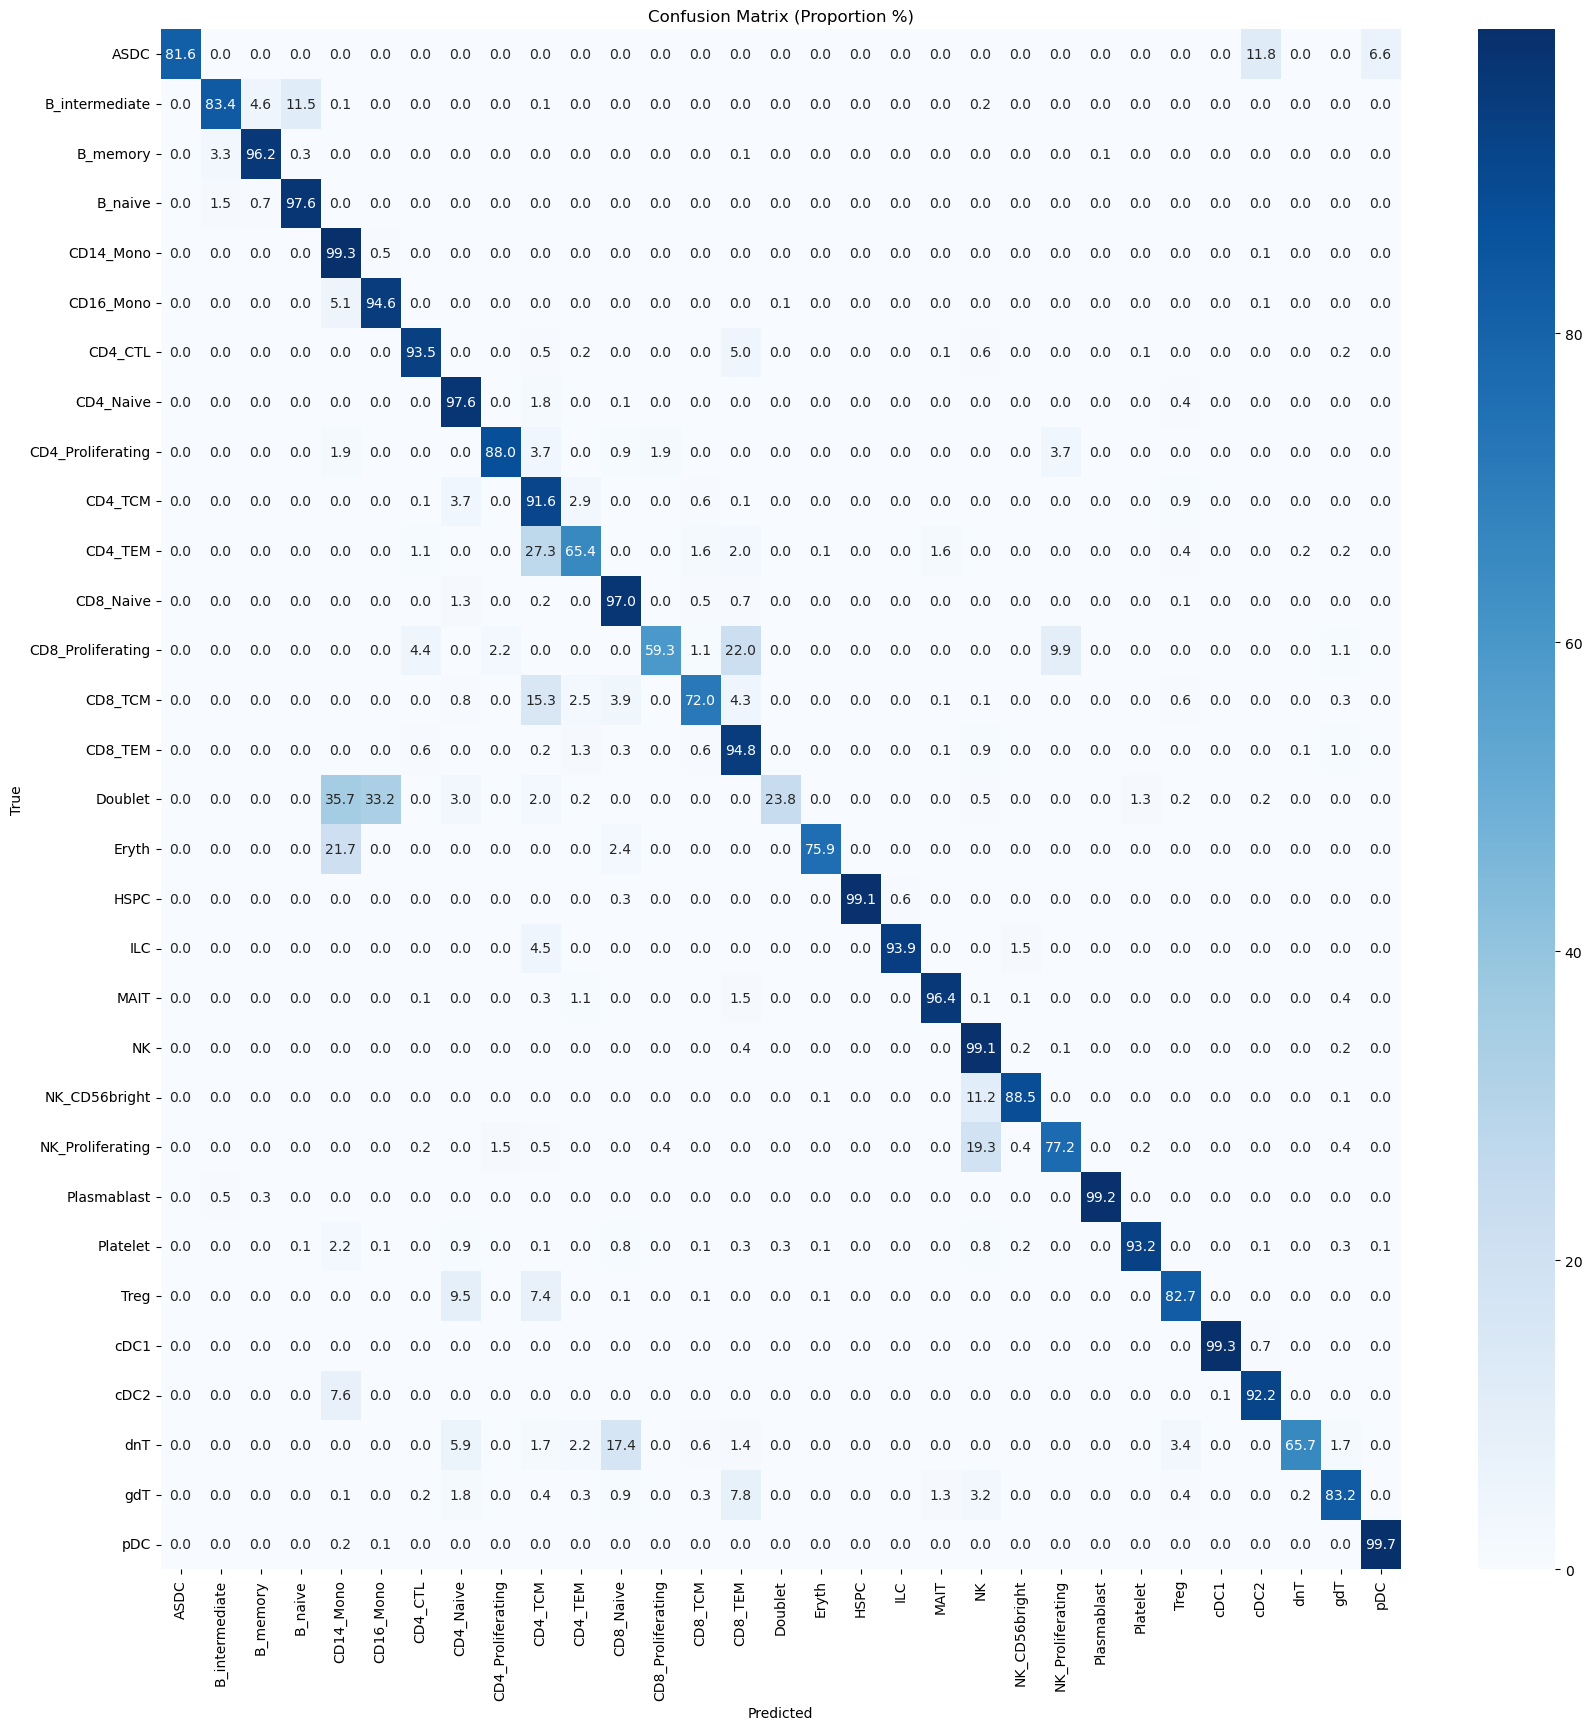

In [18]:
evan_lr.plot_confusion_matrix_proportion(confusion_matrix, figsize=(20,20))